 # CAIXA BANK  --- HACKATHON 28 mayo
 
 ##### Por Pablo Llobregat Ruiz -- Estudiante de Grado de Ciencia de Datos en Universitat Politècnica de València

Linkedin: https://www.linkedin.com/in/pablo-llobregat-ruiz-122a0419b/  

 email: pllorui@etsinf.upv.es

In [37]:
import pandas as pd
import numpy as np

In [38]:
#LECTURA DE DATOS y prelimpieza

tweets= pd.read_csv("tweets_from2015_#Ibex35.csv")
train= pd.read_csv("train.csv")
test= pd.read_csv("test_x.csv")

#Pretratamiento

train["Date"]= pd.to_datetime(train["Date"]).dt.date
train["Date"]=train["Date"].apply(str)
test["Date"]= pd.to_datetime(test["Date"]).dt.date
test["Date"]=test["Date"].apply(str)
train=train.set_index(train["Date"]).drop(["Date"],axis=1).dropna()
test=test.set_index(test["Date"]).drop(["Date"],axis=1).dropna()

In [40]:
# Limpieza de la fecha de los tweets
def to_date(date1):
    try:
        from datetime import datetime
        date=datetime.strptime(date1, '%a %b %d %H:%M:%S %z %Y')
        return date
    except: return None

tweets["tweetDate"]=tweets["tweetDate"].apply(to_date)
tweets["tweetDate"] = pd.to_datetime(tweets["tweetDate"]).dt.date
tweets= tweets.dropna()

# ¿Están relacionados los sentimientos de los tweets con la cotización del IBEX?

In [41]:
#Agrupamos por día , sumamos todas las palabras de los tweets de cada día

tweets = tweets.groupby("tweetDate").sum()["text"]

In [85]:
#Se han extraído los sentimientos de cada día en R con Syuzhet

sent_tweets = pd.read_csv("sentimientos_tweets.csv")

EN R:



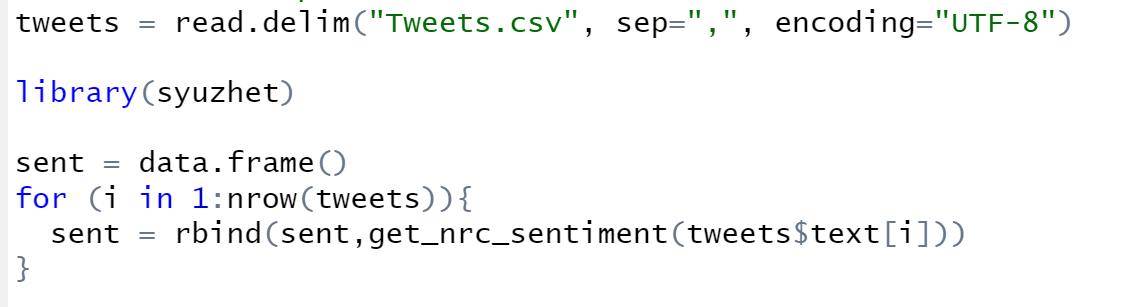

In [42]:
sent_tweets

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
Date,,,,,,,,,,
2015-01-03,0,0,0,0,0,0,0,0,0,0
2015-01-04,0,0,0,0,0,0,0,0,0,0
2015-01-05,0,0,0,0,0,0,0,0,0,0
2015-01-06,0,0,0,0,0,0,0,0,1,0
2015-01-07,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-04-05,0,0,0,0,0,0,0,0,0,0
2022-04-06,0,0,0,0,0,0,0,0,0,0
2022-04-07,2,1,1,2,1,1,0,1,3,2


In [49]:
train2= pd.DataFrame(train["Target"]).join(sent_tweets, on ="Date").fillna(0)

### Ánalisis de Componentes Principales para ver qué explica la variable TARGET

In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(train2)


PCA = PCA(n_components=2)
components = PCA.fit_transform(X_std)


In [55]:
cumVar = pd.DataFrame(np.cumsum(PCA.explained_variance_ratio_)*100, 
                      columns=["cumVarPerc"])
expVar = pd.DataFrame(PCA.explained_variance_ratio_*100, columns=["VarPerc"])
pd.concat([expVar, cumVar], axis=1).rename(index={0: "PC1", 1: "PC2",2:"PC3",3:"PC4"})

,VarPerc,cumVarPerc
PC1,45.222652,45.222652
PC2,18.800686,64.023337


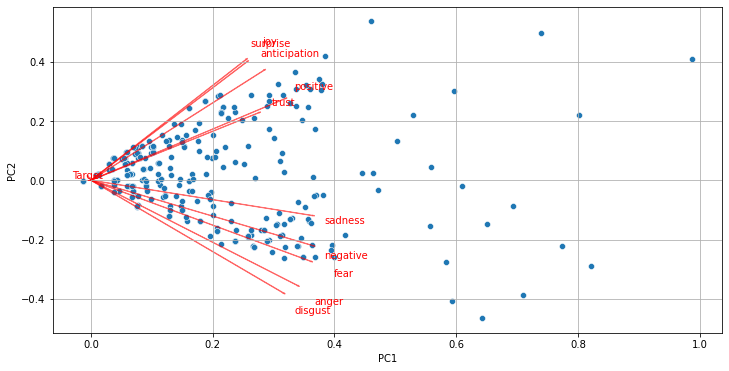

In [61]:
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    sns.scatterplot(data=componentsDf,x=xs * scalex,y=ys * scaley,palette=("Set2"))
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'red', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

plt.figure(figsize=(12, 6))
biplot(components, np.transpose(PCA.components_), list(train2.columns))

### CONCLUSIÓN sobre los sentimientos de los tweets

Como se puede apreciar en el PCA de 2 dimensiones que explica más del 64% de la variabilidad...

La variable TARGET no está explicada por los sentimientos de los tweets, por tanto, no consideraremos los tweets para nuestro modelo predictivo.

(Meter los sentimientos en el modelo predictivo solo añadiría ruido)

# PREDICIENDO COTIZACIÓN SIN TWEETS

-- Propongo crear un modelo basado en redes neuronales que dada la información de los 30 días anteriores sea capaz de predecir el TARGET

In [4]:
# Cargo librerías

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [5]:
#Escalamos los valores de la bolsa a valores entre 0 y 1


scaler= MinMaxScaler(feature_range=(0,1))

scaled_data =scaler.fit_transform(train['Open'].values.reshape(-1,1))

In [6]:
prediction_days= 30 # 30 días para predecir el Target

In [7]:
# Trasnsformamos adecuadamente el conjunto de entrenamiento para pasarselo a la red neuronal

x_train=[]
y_train=[]

for x in range(prediction_days, len(scaled_data)-2):  
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x+2,0])  # con ese +2 indicamos que queremos predecir los 3 días siguientes !!!!

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [10]:
# Transformación del conjunto de testeo 

total_dataset = pd.concat((train['Open'], test['Open']), axis=0)

model_inputs = total_dataset[len(total_dataset)- len(test) - prediction_days:].values.reshape(-1,1)
model_inputs= scaler.transform(model_inputs)

x_test=[]

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test=np.array(x_test)
x_test= np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


In [13]:


# CONSTRUCCIÓN DE LA RED NEURONAL

# consultando varias fuentes, las capas LSTM son las más adecuadas para estos casos 

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')  # Optimizador adam y error medio cuadrático
model.fit(x_train, y_train, epochs=5, batch_size=100) 



Epoch 1/5
64/64 [==============================] - 6s 46ms/step - loss: 0.0187
Epoch 2/5
64/64 [==============================] - 3s 48ms/step - loss: 0.0031
Epoch 3/5
64/64 [==============================] - 3s 48ms/step - loss: 0.0030
Epoch 4/5
64/64 [==============================] - 3s 48ms/step - loss: 0.0029
Epoch 5/5
64/64 [==============================] - 3s 48ms/step - loss: 0.0027


23/23 [==============================] - 1s 7ms/step


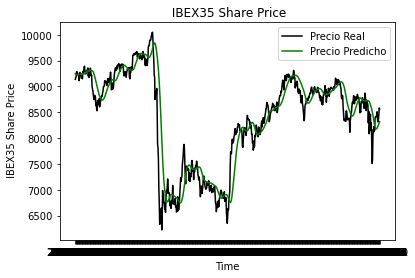

1/1 [==============================] - 1s 763ms/step
Prediction: [[8343.329]]


In [14]:
#TESTEANDO EL MODELO

actual_prices=test["Open"]

total_dataset=pd.concat((train['Open'], test['Open']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

#  Haciendo predicciones
x_test=[]

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

# Plot the test predictions
plt.plot(actual_prices, color = "black", label=f"Precio Real")
plt.plot(predicted_prices, color="green", label=f"Precio Predicho")
plt.title(f" IBEX35 Share Price")
plt.xlabel("Time")
plt.ylabel(f" IBEX35 Share Price")
plt.legend()
plt.show()

# Graficando resultados

real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data=np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction=model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

#### CREAMOS LA VARIABLE TARGET A PARTIR DE LA PREDICCIÓN 

In [78]:
# Apartir de las predicciones creamos los valores de TARGET muy facilmente

#Si la prediccion es mayor al valor actual -> 1 , si no 0


lista=[]
for i,p in enumerate(predicted_prices):
    p=p[0]
    lista.append((test["Open"][i],p))
    
    
target=[]
for tupla in lista:
    if tupla[0]>tupla[1]:
        target.append(0)
    else:
        target.append(1)

In [80]:
test["Target"]=target

Guardo las predicciones que se van a enviar

In [81]:
predictions= test.reset_index()[["test_index", "Target"]]

In [82]:
predictions

,test_index,Target
0,6557,1
1,6558,1
2,6559,1
3,6560,0
4,6561,0
...,...,...
721,7278,0
722,7279,0
723,7280,0
724,7281,0


In [83]:
predictions.to_csv("predictions.csv")

In [84]:
predictions.to_json("predictions.json")

Y envio las predicciones...                                                                       

:)